In [1]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt
from sympy import *

# Model of a Muscle

## Setting up the model

### Description of model

We model a single muscle fiber as a line segment that rotates with a stationary midpoint and stretches like a simple spring.

### Mathematical setup of model

#### Variables

Define $t$ as time, $\ell$ as the variable length of the fiber, $\dot{\ell}$ as the derivative of $\ell$ with respect to time $\frac{\mathrm{d} \ell}{\mathrm{d} t}$, $\phi$ as the counter-clockwise angle of the muscle fiber with respect to the $x$-axis, and $\dot{\phi}$ as the derivative of $\phi$ with respect to time $\frac{\mathrm{d} \phi}{\mathrm{d} t}$.

In [2]:
t, l, ldot, phi, phidot = symbols('t \ell \dot{\ell} phi \dot{\phi}')

#### Material properties

Define $\ell_0$ as the equilibrium length of the fiber, $k$ as the spring constant of the fiber, and $m$ as the mass of the fiber.

In [3]:
l0, k, m = symbols('\ell_0 k m')

Let us determine the moment of inertia $I$ about the center of the fiber.

In [4]:
I = Rational(1, 12) * m * l**2
I

\ell**2*m/12

#### Rotational kinetic energy of muscle fiber

Define $T_\mathrm{rot}$ as the rotational kinetic energy of the muscle fiber. Now let us determine $T_\mathrm{rot}$ in terms of our basic variables and material properties.

In [5]:
Trot = Rational(1, 2) * I * phidot ** 2
Trot

\dot{\phi}**2*\ell**2*m/24

#### Spring kinetic energy of muscle fiber

Define $T_k$ as the spring kinetic energy of the muscle fiber. Let us assume that the linear mass density of the fiber $\lambda = \frac{m}{\ell}$ is uniform and the speed of points on the fiber increases linearly with distance from the origin. Thus, we can subdivide the fiber into segments with mass $\mathrm{d} m$ which are a distance $x$ away from the origin. Because the points are moving away from each other with equal differences in speed, the fiber maintains a uniform mass distribution. Define the speed of either point at distance $x \leq \frac{\ell}{2}$ from the origin as $v \left( x \right)$. Let us determine $v \left( x \right)$.

In [6]:
x = symbols('x')
v = ldot * x / (l / 2)
v

2*\dot{\ell}*x/\ell

Now, let us find the differential $\mathrm{d} T_k \left( x \right)$ in terms of the differential $\mathrm{d} m$.

In [7]:
dm = symbols('\mathrm{d}m')
dTk = dm * v**2
dTk

4*\dot{\ell}**2*\mathrm{d}m*x**2/\ell**2

Now, let us rewrite the differential $\mathrm{d} m$ in terms of the differential $\mathrm{d} x$.

In [8]:
dx = symbols('\mathrm{d}x')
lam = m / l
dm = lam * dx
dm

\mathrm{d}x*m/\ell

Now let's plug this into our expression for $\mathrm{d} T_k \left( x \right)$.

In [9]:
dTk = dm * v**2
dTk

4*\dot{\ell}**2*\mathrm{d}x*m*x**2/\ell**3

Now we integrate from $x = 0$ to $x = \frac{\ell}{2}$, then double our result to account for symmetry to find $T_k$.

In [10]:
dTkint = dTk / dx
Tk = 2 * integrate(dTkint, (x, 0, l/2))
Tk

\dot{\ell}**2*m/3

#### Spring potential energy of muscle fiber

Define $U_k$ as the spring potential energy of the muscle fiber. Now let us use the standard formula for spring potential energy to find $U_k$.

In [11]:
Uk = Rational(1, 2) * k * (l - l0)**2
Uk

k*(\ell - \ell_0)**2/2

#### Lagrangian of muscle fiber

Now let us find the Lagrangian $\mathcal{L}$ by subtracting the total potential energy from the total kinetic energy.

In [12]:
L = Trot + Tk - Uk
L

\dot{\ell}**2*m/3 + \dot{\phi}**2*\ell**2*m/24 - k*(\ell - \ell_0)**2/2

#### Setting up the Euler-Lagrange equations

First, let us find $\frac{\partial \mathcal{L}}{\partial \mathcal{\ell}}$.

In [13]:
partl = diff(L, l)
partl

\dot{\phi}**2*\ell*m/12 - k*(2*\ell - 2*\ell_0)/2

Now, let us find $\frac{\partial \mathcal{L}}{\partial \dot{\ell}}$.

In [14]:
partldot = diff(L, ldot)
partldot

2*\dot{\ell}*m/3

Finally, let us find $\frac{\partial \mathcal{L}}{\partial \dot{\phi}}$.

In [15]:
partphidot = diff(L, phidot)
partphidot

\dot{\phi}*\ell**2*m/12

Now, let us find the generalized momentum $p_\ell = \frac{\mathrm{d}}{\mathrm{d} t} \left( \frac{\partial \mathcal{L}}{\partial \dot{\ell}} \right)$.

In [16]:
lddot = symbols('\ddot{\ell}')
pl = Rational(2, 3) * lddot * m
pl

2*\ddot{\ell}*m/3

Now, let us find the generalized momentum $p_\phi = \frac{\mathrm{d}}{\mathrm{d} t} \left( \frac{\partial \mathcal{L}}{\partial \dot{\phi}} \right)$.

In [17]:
phiddot = symbols('\ddot{\phi}')
pphi = phiddot * l**2 * m / 12 + phidot * l * ldot * m / 6
pphi

\ddot{\phi}*\ell**2*m/12 + \dot{\ell}*\dot{\phi}*\ell*m/6

Let us find $\frac{\partial \mathcal{L}}{\partial \ell} - p_\ell$, which is equal to $0$.

In [18]:
eq0l = partl - pl
eq0l

-2*\ddot{\ell}*m/3 + \dot{\phi}**2*\ell*m/12 - k*(2*\ell - 2*\ell_0)/2

Let us find $\frac{\partial \mathcal{L}}{\partial \phi} - p_\phi$, which is equal to $0$.

In [19]:
eq0phi = 0 - pphi
eq0phi

-\ddot{\phi}*\ell**2*m/12 - \dot{\ell}*\dot{\phi}*\ell*m/6

## Solving the motion of the model

### Euler's method

To implement Euler's method, we will subdivide the motion into small timeframes of duration $\Delta t$. In each timeframe, we assume constant values for $\ddot{\ell} \left( t \right)$ and $\ddot{\phi} \left( t \right)$. We then calculate the values at the end of the timeframe $\dot{\ell} \left( t + \Delta t \right) = \dot{\ell} \left( t \right) + \ddot{\ell} \left( t \right) \Delta t$, $\dot{\phi} \left( t + \Delta t \right) = \dot{\phi} \left( t \right) + \ddot{\phi} \left( t \right) \Delta t$, $\ell \left( t + \Delta t \right) = \ell \left( t \right) + \dot{\ell}_n \Delta t + \frac{1}{2} \ddot{\ell} \left( t \right) \Delta t^2$, and $\phi \left( t + \Delta t \right) = \phi \left( t \right) + \dot{\phi}_n \Delta t + \frac{1}{2} \ddot{\phi} \left( t \right) \Delta t^2$.

Now, we must solve for $\ddot{\ell}$ and $\ddot{\phi}$ in terms of the other variables. Let us first solve for $\ddot{\ell}$.

In [20]:
lddotn = (- eq0l - Rational(2, 3) * lddot * m) / (- Rational(2, 3) * m)
lddotn

-3*(-\dot{\phi}**2*\ell*m/12 + k*(2*\ell - 2*\ell_0)/2)/(2*m)

Now, let us solve for $\ddot{\phi}$.

In [21]:
phiddotn = (- eq0phi - phiddot * l**2 * m / 12) / (- (l**2 * m / 12))
phiddotn

-2*\dot{\ell}*\dot{\phi}/\ell

### Numerical solution

In [22]:
def lval(l_val, phid_val, l0_val, m_val, k_val):
    return - (3 * (- (phid_val**2 * l_val * m_val) / 12 + k_val * (2 * l_val - 2 * l0_val) / 2)) / (2 * m_val)

def phival(l_val, ld_val, phid_val):
    return - 2 * ld_val * phid_val / l_val

In [23]:
l0_num = 1
m_num = 1
k_num = 1

l_init = l0_num
phi_init = 0
ldot_init = 0
phidot_init = 2 * np.pi
delta_t = 0.01
t_init = 0
t_max = 4

l_vals = []
phi_vals = []
t_vals = []

t_num = t_init
l_num = l_init
phi_num = phi_init
ldot_num = ldot_init
phidot_num = phidot_init

while t_num <= t_max:
    t_vals.append(t_num)
    l_vals.append(l_num)
    phi_vals.append(phi_num)
    
    lddot_num = lval(l_num, phidot_num, l0_num, m_num, k_num)
    phiddot_num = phival(l_num, ldot_num, phidot_num)
    
    l_num = l_num + ldot_num * delta_t + (1/2) * lddot_num * delta_t**2
    phi_num = phi_num + phidot_num * delta_t + (1/2) * lddot_num * delta_t**2
    ldot_num = ldot_num + lddot_num * delta_t
    phidot_num = phidot_num + phiddot_num * delta_t
    t_num = t_num + delta_t

Text(0, 0.5, 'l (m)')

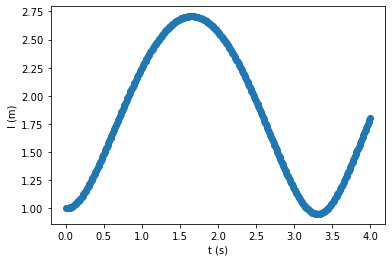

In [24]:
plt.scatter(t_vals, l_vals)
plt.xlabel('t (s)')
plt.ylabel('l (m)')

Text(0, 0.5, 'phi (rad)')

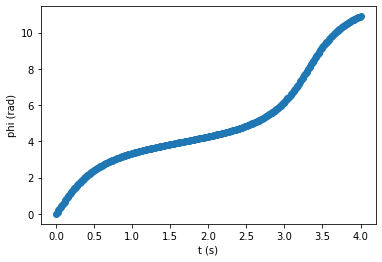

In [25]:
plt.scatter(t_vals, phi_vals)
plt.xlabel('t (s)')
plt.ylabel('phi (rad)')